In [2]:
# import libraries
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# read in data
df_diabetes = pd.read_csv('C:\\Users\\Kevin Sharp\\Desktop\\Springboard\\2014_BRFSS_encoded.csv')
df_diabetes.head()

,general_health,10yr_age_group,bmi_category,last_checkup,income,race,mscode,flushot,employed,sex,...,mental_health_days_per_month,kidney_disease,depressive_disorder,uses_medical_equipment,rent_or_own_home,any_exercise,blindness,trouble_concentrating,diabetes,smoker
0,5.0,4,3.0,1.0,7.0,7.0,5.0,1.0,8.0,2,...,2,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0
1,1.0,3,4.0,1.0,7.0,1.0,3.0,2.0,1.0,1,...,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0
2,3.0,4,4.0,1.0,4.0,1.0,2.0,1.0,7.0,2,...,1,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,4.0
3,3.0,6,4.0,1.0,6.0,2.0,3.0,1.0,7.0,1,...,2,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,4.0
4,2.0,4,3.0,1.0,8.0,1.0,3.0,2.0,7.0,1,...,1,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0


For this project, I will be build logistic regression model to predict the risk of diabetes in responants to the 2014 BRFSS. Those with diabetes make up a minority of both the general population and the sample data, which will affect how I approach contructing the model.

In [6]:
#"no" response was encoded as 3; change these to 0 for clarity
df_diabetes.loc[(df_diabetes['diabetes'] == 3), 'diabetes'] = 0

#verify unbalanced nature of the data
df_diabetes['diabetes'].value_counts()/df_diabetes.shape[0]

0.0    0.844994
1.0    0.155006
Name: diabetes, dtype: float64

First, we split the data into training and testing sets. I use the default 25/75 ratio of training data to testing data.

In [7]:
#create train-test split
from sklearn.model_selection import train_test_split

X = df_diabetes.drop('diabetes', axis=1)
y = df_diabetes['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [58]:
from yellowbrick.classifier import ClassificationReport

def plot_classification_report(model, version_number):
    visualizer = ClassificationReport(model, classes=['diabetes-negative', 'diabetes-positive'], support=False,
                                     title=f'Logistic Regression Classification Report {version_number}')

    visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and show the figure
    
    y_pred = model.predict(X_test)
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5))
    print(f'roc_auc score: {score}')
    
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5))
    print(f'accuracy score: {score}')

Initially, I use a basic logistic regression model with no additional parameters to use as a control for the tuning I expect to perform at a later step. As a reminder, 0 indicates a diabetes negative response, while 1 indicates a diabetes positive response.

C:\Users\Kevin Sharp\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


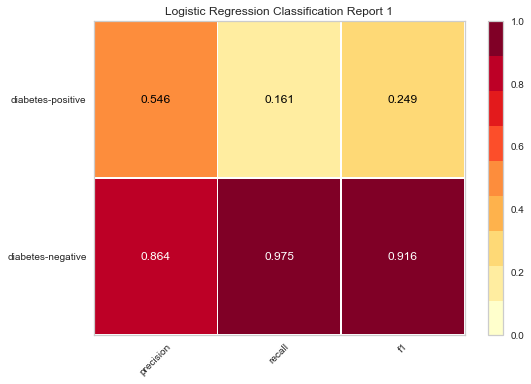

roc_auc score: 0.797313317598487
accuracy score: 0.848691698978033


In [59]:
#establishing baseline naive model to use as a control for further tuning

model = LogisticRegression(max_iter=1000)
#model.fit(X_train, y_train)

plot_classification_report(model, 1)

The printed table of metrics shows us the effect of modeling unbalanced data. Although the model's accuracy is a fine 85%, we find a recall of only 16% for those with diabetes; in other words, the remaining 84% of those with diabetes were reported as false negatives by the model, which has a strong negative effect on the $f_1$ score. Since we are primarily interested in identifying those with diabetes, I will retune the model to assign class weights proportional to their frequency in the data.

C:\Users\Kevin Sharp\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


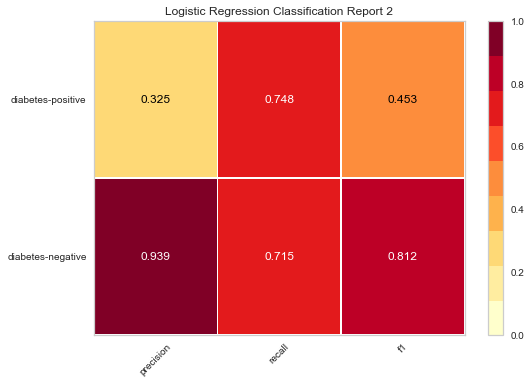

roc_auc score: 0.7975536781714669
accuracy score: 0.7136401455082246


In [60]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
#model.fit(X_train, y_train)

plot_classification_report(model, 2)

Already, we see a marked improvement in the rate of recall and the $f_1$ score for diabetes-positive, and the ROC AUC score remains about the same at roughly 0.80. Although the $f_1$ score for diabetes-negative drops slightly, I more strongly consider regard the increased performance on diabetes-positive and consider this a net improvement. I will next attempt to tune the model further by adjusting the regularization parameter $C$. I also provide a range of possible weights to allow the model more flexibility.

In [55]:
#create hyperparameter grid for grid search CV 
from sklearn.model_selection import GridSearchCV

Cs = [0.001, 0.1, 1, 10, 100]
Ws = [{1:84.4994, 0:15.5006}, {1:84, 0:16}, {1:80, 0:20}, {1:75, 0:25}]
hyperparam_grid = {"C":Cs, "class_weight":Ws}

In [56]:
model = LogisticRegression(max_iter=1000)

grid = GridSearchCV(model, hyperparam_grid, scoring='roc_auc')
grid.fit(X_train, y_train)
print(f'best score: {grid.best_score_}\nbest parameters: {grid.best_params_}')

best score: 0.7975670233499523
best parameters: {'C': 100, 'class_weight': {1: 80, 0: 20}}


C:\Users\Kevin Sharp\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


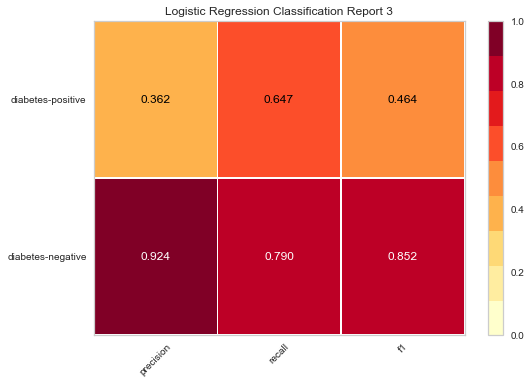

roc_auc score: 0.7975654487203315
accuracy score: 0.7630039470294111


In [61]:
C = grid.best_params_['C']
class_weight = grid.best_params_['class_weight']

model = LogisticRegression(max_iter=1000, class_weight=class_weight)
#model.fit(X_train, y_train)
plot_classification_report(model, 3)

This updated model uses a value of 100 for $C$ instead of the default 1 and adjusts the class weights a bit. The ROC AUC score is once again about 0.80, and accuracy is increased from 72% to 76%. Both $f_1$ scores are slightly higher in this version of the model compared to the version that considers class weights but not the regularization parameter. I believe this version of the model is sufficient to move forward with a final analysis of the predictor variables.

In [10]:
df_coef = pd.DataFrame()
df_coef['coefficients'] = model.coef_[0]
df_coef['features'] = X.columns
df_coef = df_coef.loc[df_coef['coefficients'].abs().argsort()]    #sort by absolute value of coefficients

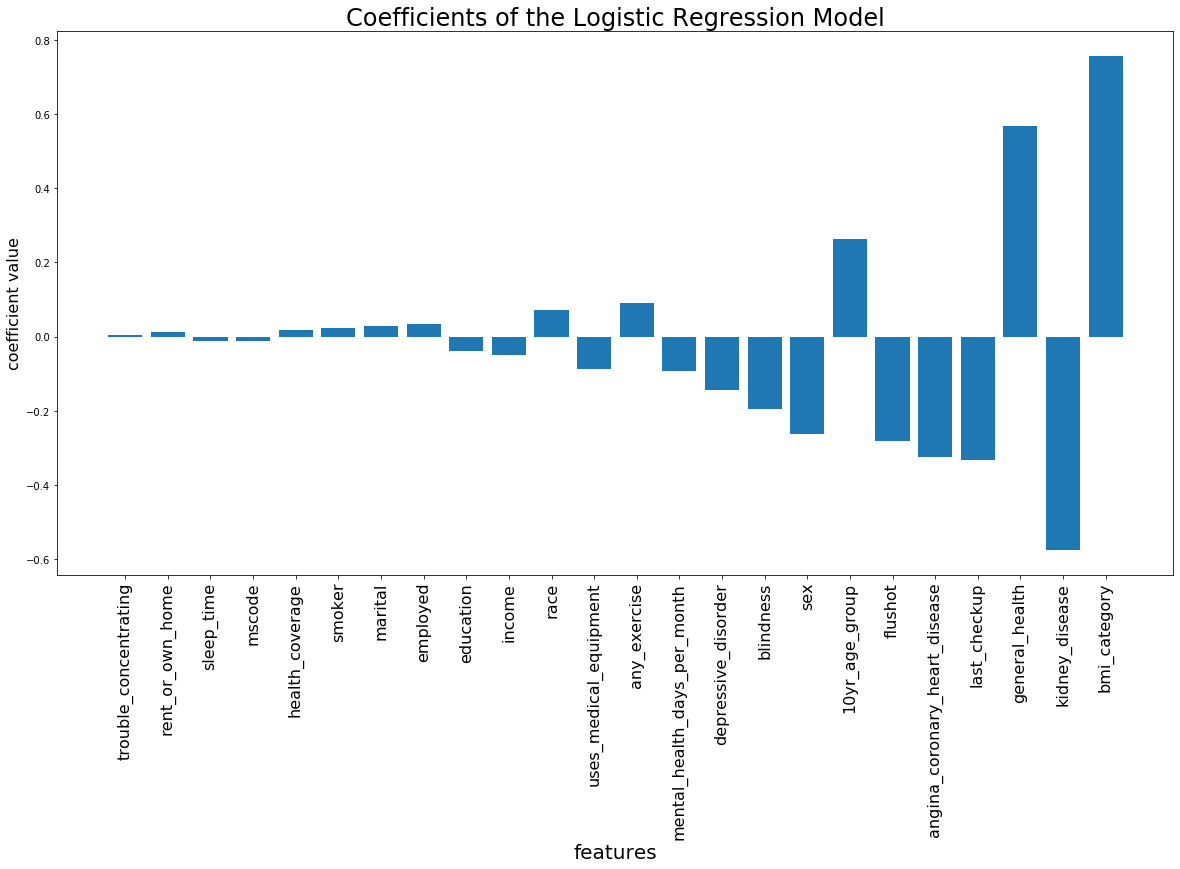

In [11]:
fig = plt.figure(figsize=(20,10))

plt.bar(df_coef['features'], df_coef['coefficients'])
plt.xticks(rotation=90, fontsize=16)
plt.title("Coefficients of the Logistic Regression Model", fontsize=24)
plt.xlabel("features", fontsize=20)
plt.ylabel("coefficient value", fontsize=16)
plt.show()

Conclusions
---

As a reminder, the model itself does not establish the direction of causality between the predictors and the incidence of diabetes; conclusions about causality are derived from general medical knowledge about the causes and outcomes associated with diabetes.

Based on the results from the final version of thge model, the five strongest predictors for diabetes are `bmi_category`, `kidney_disease`, `general_health`, `last_checkup`, and `angina_coronary_heart_disease`. Predictably, as a person's weight increases and their general health worsens, do does their risk of diabetes. Kidney disease, angina, and coronary heart disease in general are negative health outcomes shown to be strong predictors of a prior onset of diabetes. Finally, as discussed in the section on exploratory data analysis, those with diabetes are perhaps more likely to vist their doctor frequently in order to monitor their condition.